In [1]:
import json
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.decomposition import PCA
import sklearn.feature_extraction.text as sk_text
from sklearn.manifold import TSNE
import torch

sys.path.append(os.path.abspath('..'))
from ludii_datasets import _collect_games

In [2]:
concept_data = json.load(open("../caches/board_game_concepts.json", "r"))

In [3]:
joined_categories = ["-".join(data["categories"][1:3]) for data in concept_data]
top_level_categories = [data["categories"][1] for data in concept_data]
bottom_level_categories = [data["categories"][-1] for data in concept_data]

In [53]:
TOP_LEVEL_COLOR_MAP = {
    "hunt": "green",
    "race": "blue",
    "sow": "purple",
    "space": "orange",
    "war": "red",
}

In [4]:
not_none_idxs = np.where(np.array(concept_data[0]["all_concepts"]) != None)[0].tolist()

In [5]:
boolean_concepts = [np.array(data["boolean_concepts"], dtype=np.int16) for data in concept_data]
all_concepts = [np.array(data["all_concepts"], dtype=np.float32)[not_none_idxs] for data in concept_data]

### Save PCA models at different dimensions

In [6]:
for name, concept_list in zip(["all", "boolean"], [all_concepts, boolean_concepts]):
    # for dim in [2, 10, 50, 100]:
    for dim in [3, 4, 5, 6, 7]:
        pca = PCA(n_components=dim)
        pca.fit(concept_list)
        
        filename = f"../caches/{name}_concepts_pca_{dim}.pkl"
        pickle.dump(pca, open(filename, "wb"))


# Analyzing the Variance Explained by Principal Components

In [46]:
pca = PCA()
pca.fit(boolean_concepts)
boolean_cumsum = np.cumsum(pca.explained_variance_ratio_)

pca = PCA()
pca.fit(all_concepts)
all_cumsum = np.cumsum(pca.explained_variance_ratio_)

Number of dimensions to explain 95% of variance for boolean concepts: 105


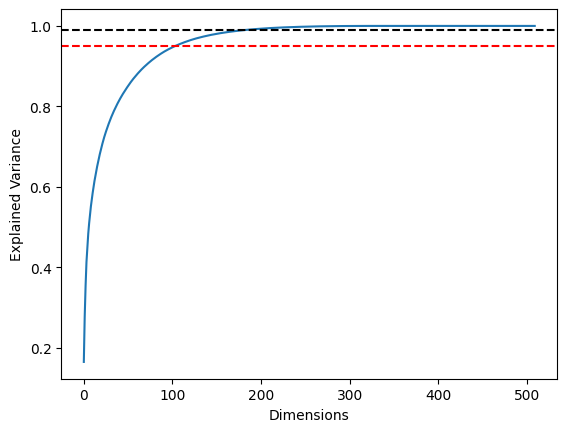

In [52]:
d_boolean = np.argmax(boolean_cumsum >= 0.95) + 1
# d_all = np.argmax(all_cumsum >= 0.95) + 1

plt.plot(boolean_cumsum, label="Boolean Concepts")
# plt.plot(all_cumsum, label="All Concepts")
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")

# Horizontal line at y = 0.95
plt.axhline(y=0.95, color='red', linestyle='--')
plt.axhline(y=0.99, color='black', linestyle='--')

print(f"Number of dimensions to explain 95% of variance for boolean concepts: {d_boolean}")
# print(f"Number of dimensions to explain 95% of variance for all concepts: {d_all}")

# Plotting the Pairwise Distances is Feature Space

In [89]:
pca = PCA(n_components=100)
pca_boolean_concepts = pca.fit_transform(boolean_concepts)

tsne = TSNE(n_components=2, random_state=0)
tsne_boolean_concepts = tsne.fit_transform(pca_boolean_concepts)

/Users/gray/anaconda3/envs/ludii-lms/lib/python3.10/site-packages/threadpoolctl.py:1186: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [96]:
np.array(boolean_concepts).shape, pca_boolean_concepts.shape, tsne_boolean_concepts.shape

((1045, 510), (1045, 100), (1045, 2))

In [97]:
concepts_by_top_level = {}
pca_concepts_by_top_level = {}
tsne_concepts_by_top_level = {}

for concepts, pca_concepts, tsne_concepts, top_level in zip(boolean_concepts, pca_boolean_concepts, tsne_boolean_concepts, top_level_categories):
    if top_level not in concepts_by_top_level:
        concepts_by_top_level[top_level] = []
        pca_concepts_by_top_level[top_level] = []
        tsne_concepts_by_top_level[top_level] = []
    
    concepts_by_top_level[top_level].append(concepts)
    pca_concepts_by_top_level[top_level].append(pca_concepts)
    tsne_concepts_by_top_level[top_level].append(tsne_concepts)

for top_level in top_level_categories:
    concepts_by_top_level[top_level] = torch.tensor(concepts_by_top_level[top_level], dtype=torch.float32)
    pca_concepts_by_top_level[top_level] = torch.tensor(pca_concepts_by_top_level[top_level], dtype=torch.float32)
    tsne_concepts_by_top_level[top_level] = torch.tensor(tsne_concepts_by_top_level[top_level], dtype=torch.float32)

/var/folders/rd/wt3q313n7j9002x_474dmbz00000gn/T/ipykernel_1280/1423117125.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  concepts_by_top_level[top_level] = torch.tensor(concepts_by_top_level[top_level], dtype=torch.float32)
/var/folders/rd/wt3q313n7j9002x_474dmbz00000gn/T/ipykernel_1280/1423117125.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pca_concepts_by_top_level[top_level] = torch.tensor(pca_concepts_by_top_level[top_level], dtype=torch.float32)
/var/folders/rd/wt3q313n7j9002x_474dmbz00000gn/T/ipykernel_1280/1423117125.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_g

In [98]:
concepts_by_top_level["hunt"].shape, pca_concepts_by_top_level["hunt"].shape, tsne_concepts_by_top_level["hunt"].shape

(torch.Size([76, 510]), torch.Size([76, 100]), torch.Size([76, 2]))

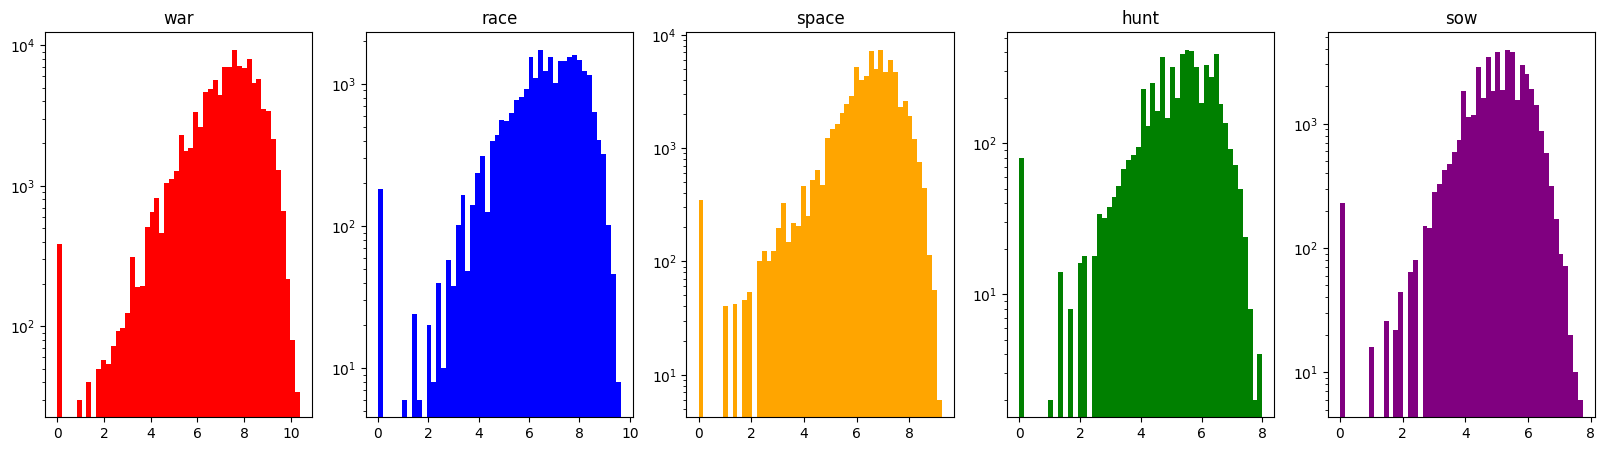

In [70]:
# Histogram the pairwise distances within each top-level category
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i, (top_level, concepts) in enumerate(concepts_by_top_level.items()):
    distances = torch.cdist(concepts, concepts, p=2)
    distances = distances.flatten()
    axes[i].hist(distances.numpy(), bins=50, color=TOP_LEVEL_COLOR_MAP[top_level])
    axes[i].set_title(top_level)
    axes[i].set_yscale("log")

plt.show()

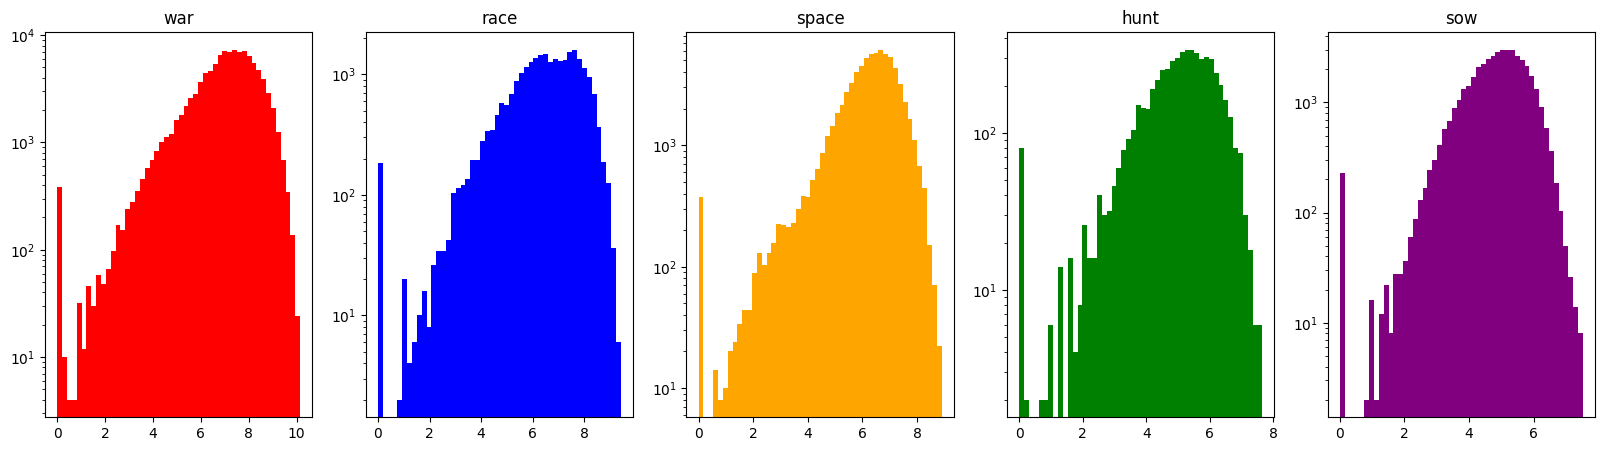

In [78]:
# Again, for the PCA'd concepts
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i, (top_level, concepts) in enumerate(pca_concepts_by_top_level.items()):
    distances = torch.cdist(concepts, concepts, p=2)
    distances = distances.flatten()
    axes[i].hist(distances.numpy(), bins=50, color=TOP_LEVEL_COLOR_MAP[top_level])
    axes[i].set_title(top_level)
    axes[i].set_yscale("log")

In [99]:
# Compute all within-category distances
all_within_category_distances = torch.cat([torch.cdist(concepts, concepts, p=2).flatten() for concepts in concepts_by_top_level.values()]).flatten()
all_within_category_pca_distances = torch.cat([torch.cdist(concepts, concepts, p=2).flatten() for concepts in pca_concepts_by_top_level.values()]).flatten()
all_within_category_tsne_distances = torch.cat([torch.cdist(concepts, concepts, p=2).flatten() for concepts in tsne_concepts_by_top_level.values()]).flatten()

# Compute all between-category distances
all_between_category_distances = torch.cat([torch.cdist(concepts, other_concepts, p=2).flatten() for top_level, concepts in concepts_by_top_level.items() for other_top_level, other_concepts in concepts_by_top_level.items() if top_level != other_top_level]).flatten()
all_between_category_pca_distances = torch.cat([torch.cdist(concepts, other_concepts, p=2).flatten() for top_level, concepts in pca_concepts_by_top_level.items() for other_top_level, other_concepts in pca_concepts_by_top_level.items() if top_level != other_top_level]).flatten()
all_between_category_tsne_distances = torch.cat([torch.cdist(concepts, other_concepts, p=2).flatten() for top_level, concepts in tsne_concepts_by_top_level.items() for other_top_level, other_concepts in tsne_concepts_by_top_level.items() if top_level != other_top_level]).flatten()


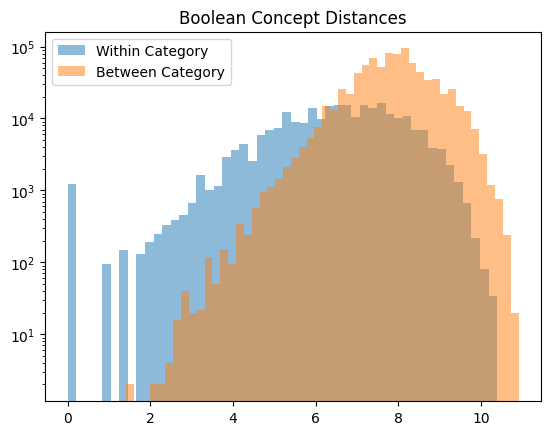

In [87]:
# Plot the histograms
plt.hist(all_within_category_distances.numpy(), bins=50, alpha=0.5, label="Within Category")
plt.hist(all_between_category_distances.numpy(), bins=50, alpha=0.5, label="Between Category")

plt.yscale("log")
plt.legend()
plt.title("Boolean Concept Distances")

plt.show()

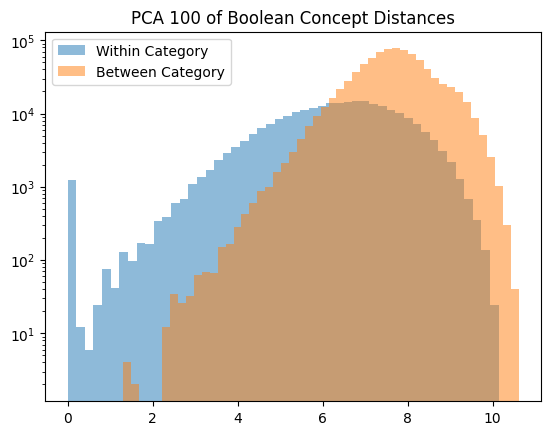

In [88]:
plt.hist(all_within_category_pca_distances.numpy(), bins=50, alpha=0.5, label="Within Category")
plt.hist(all_between_category_pca_distances.numpy(), bins=50, alpha=0.5, label="Between Category")

plt.yscale("log")
plt.legend()
plt.title("PCA 100 of Boolean Concept Distances")

plt.show()

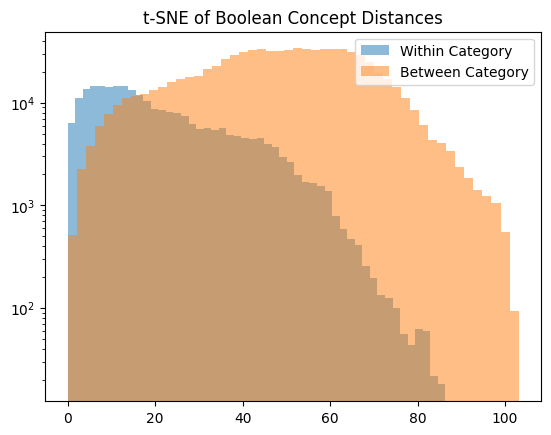

In [100]:
plt.hist(all_within_category_tsne_distances.numpy(), bins=50, alpha=0.5, label="Within Category")
plt.hist(all_between_category_tsne_distances.numpy(), bins=50, alpha=0.5, label="Between Category")

plt.yscale("log")
plt.legend()
plt.title("t-SNE of Boolean Concept Distances")

plt.show()

In [71]:
torch.cdist(concepts_by_top_level["hunt"], concepts_by_top_level["war"], p=2)

tensor([[7.4162, 6.4807, 6.2450,  ..., 8.6603, 9.0000, 7.9373],
        [7.0000, 7.0711, 6.8557,  ..., 9.0000, 9.4340, 7.6811],
        [6.9282, 7.5498, 7.4833,  ..., 8.7178, 9.1652, 7.6158],
        ...,
        [7.4162, 6.3246, 6.7082,  ..., 8.8882, 9.1104, 8.1854],
        [5.9161, 6.6332, 6.5574,  ..., 8.1854, 9.0000, 7.0000],
        [7.0000, 7.7460, 7.6811,  ..., 8.5440, 8.6603, 7.9373]])

# Using PCA and t-SNE to Visualize Clusters in Concept Space

In [102]:
pca = PCA(n_components=50)
pca_boolean_concepts = pca.fit_transform(boolean_concepts)

pca_2 = PCA(n_components=2)
pca_boolean_concepts_2 = pca_2.fit_transform(boolean_concepts)

tsne = TSNE(n_components=2, random_state=0)
tsne_boolean_concepts = tsne.fit_transform(pca_boolean_concepts)

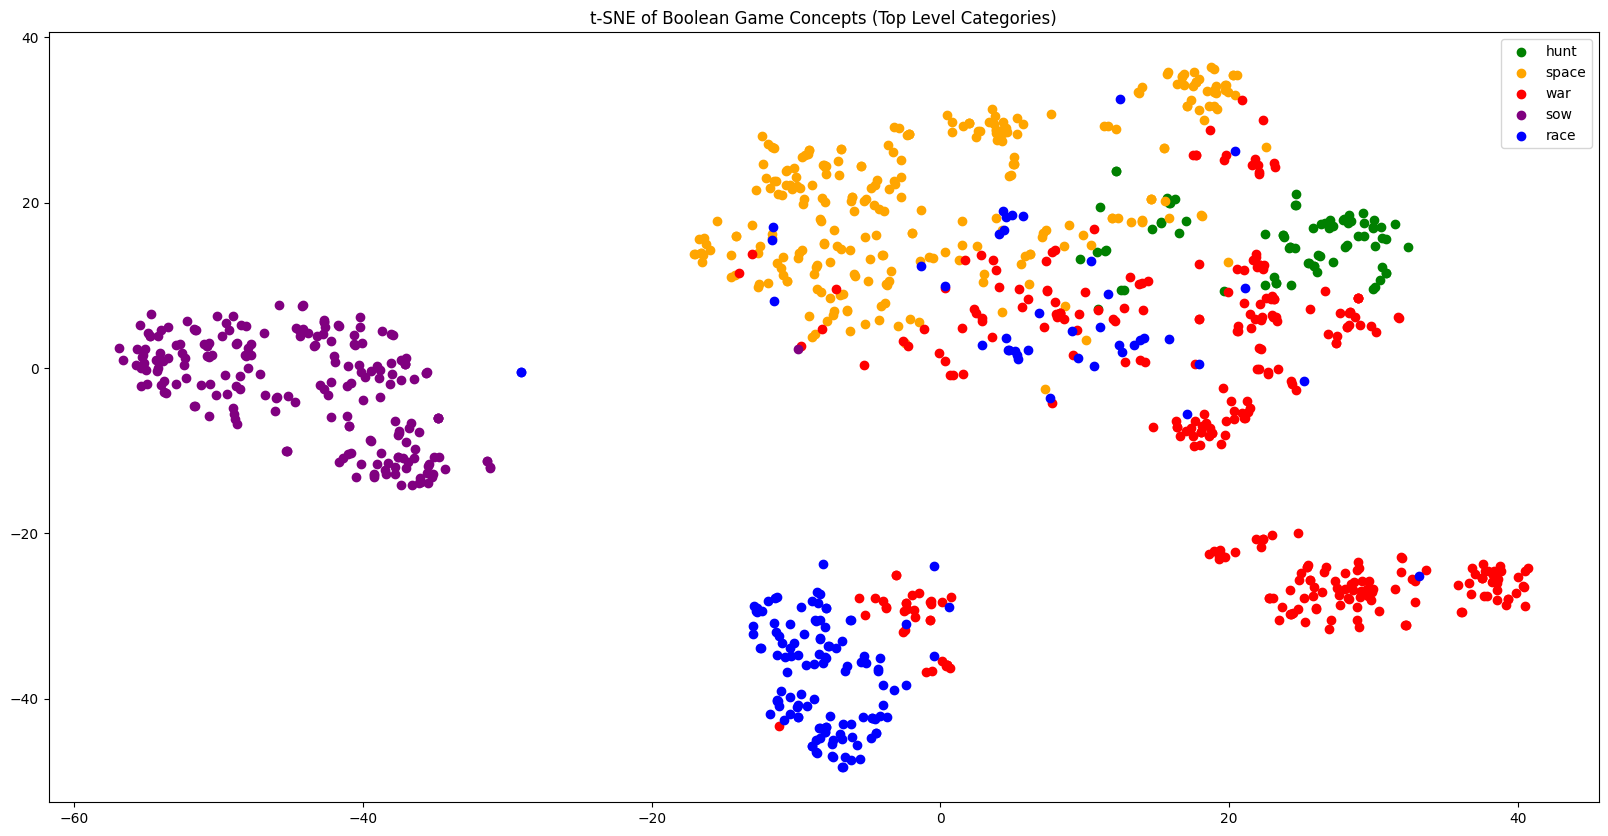

In [103]:
plt.figure(figsize=(20, 10))

for cat in set(top_level_categories):
    indices = [i for i, x in enumerate(top_level_categories) if x == cat]
    plt.scatter(tsne_boolean_concepts[indices, 0], tsne_boolean_concepts[indices, 1], color=TOP_LEVEL_COLOR_MAP[cat], label=cat)

plt.title('t-SNE of Boolean Game Concepts (Top Level Categories)')
plt.legend()

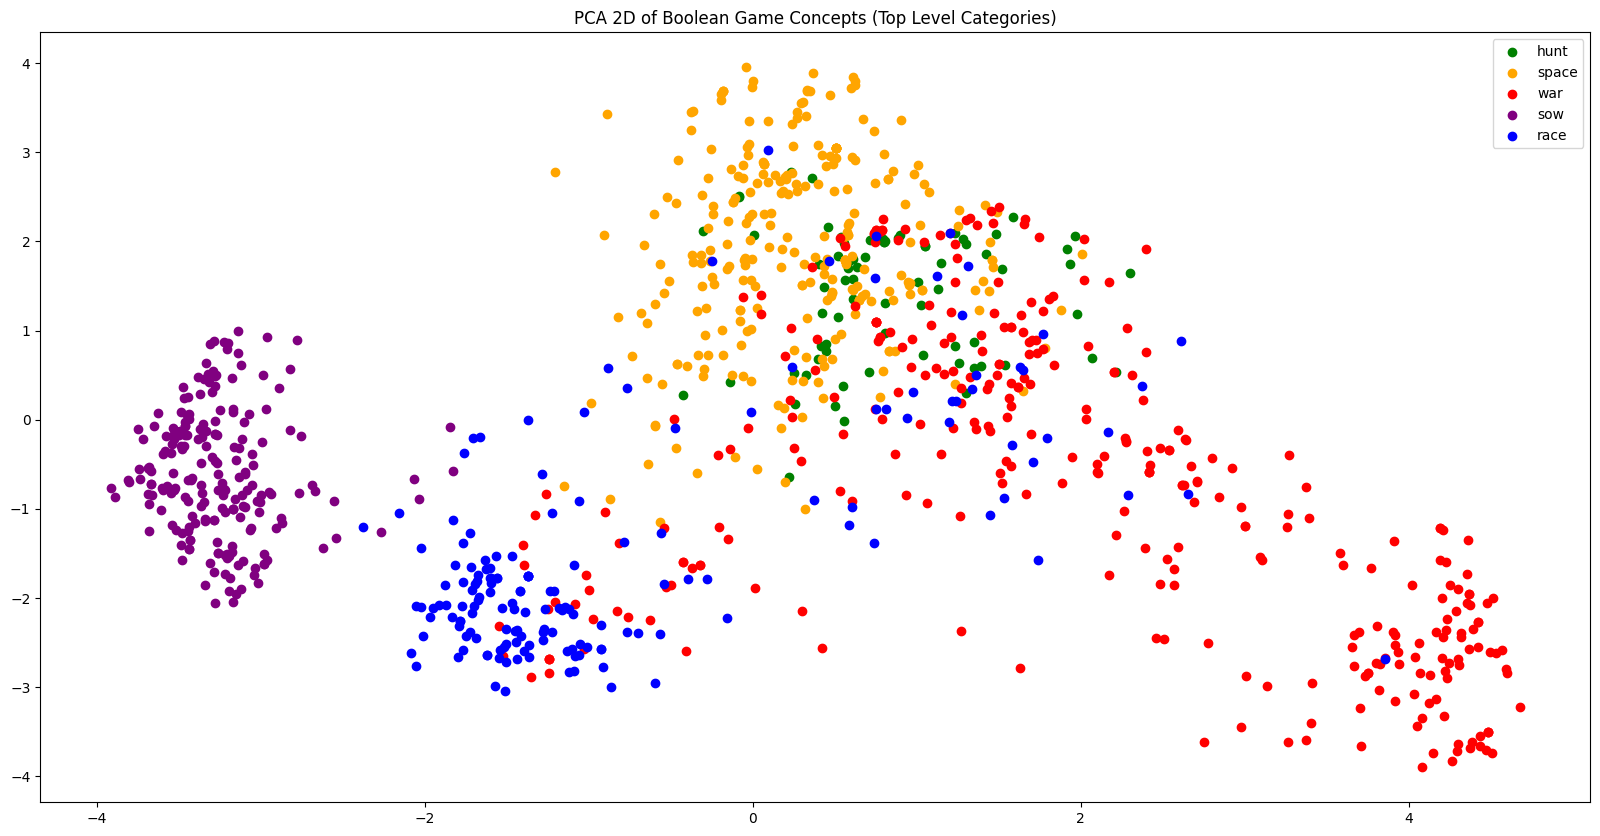

In [105]:
plt.figure(figsize=(20, 10))

for cat in set(top_level_categories):
    indices = [i for i, x in enumerate(top_level_categories) if x == cat]
    plt.scatter(pca_boolean_concepts_2[indices, 0], pca_boolean_concepts_2[indices, 1], color=TOP_LEVEL_COLOR_MAP[cat], label=cat)

plt.title('PCA 2D of Boolean Game Concepts (Top Level Categories)')
plt.legend()

In [8]:
import math

import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.cm import hsv


def generate_colormap(number_of_distinct_colors: int = 80):
    if number_of_distinct_colors == 0:
        number_of_distinct_colors = 80

    number_of_shades = 7
    number_of_distinct_colors_with_multiply_of_shades = int(math.ceil(number_of_distinct_colors / number_of_shades) * number_of_shades)

    # Create an array with uniformly drawn floats taken from <0, 1) partition
    linearly_distributed_nums = np.arange(number_of_distinct_colors_with_multiply_of_shades) / number_of_distinct_colors_with_multiply_of_shades

    # We are going to reorganise monotonically growing numbers in such way that there will be single array with saw-like pattern
    #     but each saw tooth is slightly higher than the one before
    # First divide linearly_distributed_nums into number_of_shades sub-arrays containing linearly distributed numbers
    arr_by_shade_rows = linearly_distributed_nums.reshape(number_of_shades, number_of_distinct_colors_with_multiply_of_shades // number_of_shades)

    # Transpose the above matrix (columns become rows) - as a result each row contains saw tooth with values slightly higher than row above
    arr_by_shade_columns = arr_by_shade_rows.T

    # Keep number of saw teeth for later
    number_of_partitions = arr_by_shade_columns.shape[0]

    # Flatten the above matrix - join each row into single array
    nums_distributed_like_rising_saw = arr_by_shade_columns.reshape(-1)

    # HSV colour map is cyclic (https://matplotlib.org/tutorials/colors/colormaps.html#cyclic), we'll use this property
    initial_cm = hsv(nums_distributed_like_rising_saw)

    lower_partitions_half = number_of_partitions // 2
    upper_partitions_half = number_of_partitions - lower_partitions_half

    # Modify lower half in such way that colours towards beginning of partition are darker
    # First colours are affected more, colours closer to the middle are affected less
    lower_half = lower_partitions_half * number_of_shades
    for i in range(3):
        initial_cm[0:lower_half, i] *= np.arange(0.2, 1, 0.8/lower_half)

    # Modify second half in such way that colours towards end of partition are less intense and brighter
    # Colours closer to the middle are affected less, colours closer to the end are affected more
    for i in range(3):
        for j in range(upper_partitions_half):
            modifier = np.ones(number_of_shades) - initial_cm[lower_half + j * number_of_shades: lower_half + (j + 1) * number_of_shades, i]
            modifier = j * modifier / upper_partitions_half
            initial_cm[lower_half + j * number_of_shades: lower_half + (j + 1) * number_of_shades, i] += modifier

    return ListedColormap(initial_cm)

In [14]:
# colormap = generate_colormap(len(set(joined_categories)))
colormap = plt.cm.get_cmap('tab20', len(set(joined_categories)))

/var/folders/rd/wt3q313n7j9002x_474dmbz00000gn/T/ipykernel_6067/337284497.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab20', len(set(joined_categories)))


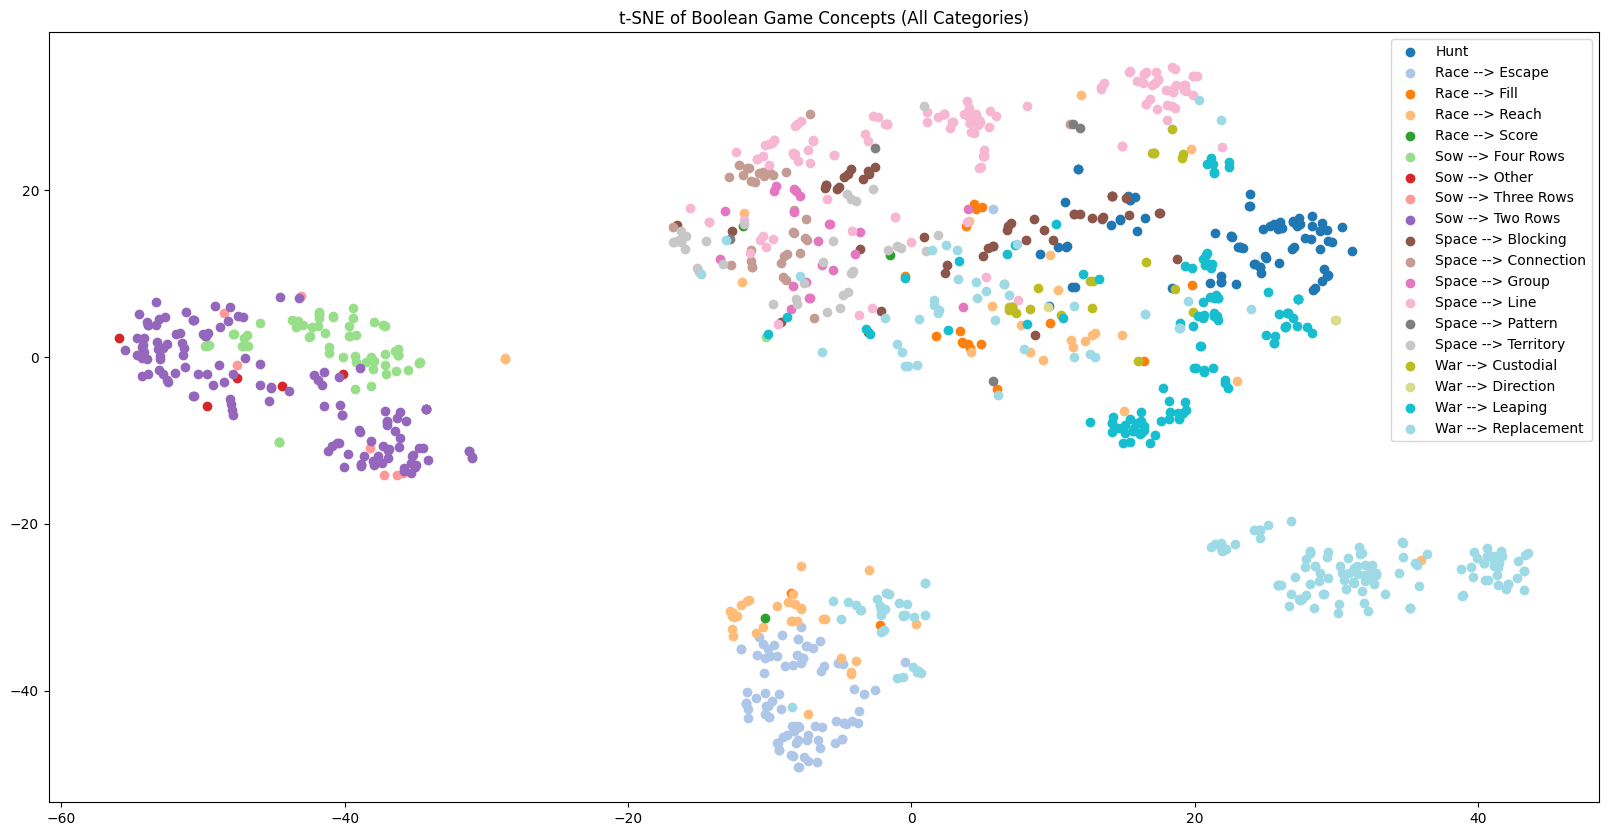

In [15]:
plt.figure(figsize=(20, 10))

all_offsets = []
for idx, cat in enumerate(sorted(list(set(joined_categories)))):
    indices = [i for i, x in enumerate(joined_categories) if x == cat]

    label_name = " --> ".join([x.replace("_", " ").title() for x in cat.split("-")])
    offsets = plt.scatter(tsne_boolean_concepts[indices, 0], tsne_boolean_concepts[indices, 1], color=colormap.colors[idx], label=label_name)
    all_offsets.append(offsets.get_offsets().data)

plt.title('t-SNE of Boolean Game Concepts (All Categories)')
plt.legend()

In [11]:
all_offsets[0].get_offsets().data

AttributeError: 'numpy.ndarray' object has no attribute 'get_offsets'